# Mixed Lp norm gravity inversion

## Input packages

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12

import numpy as np

from discretize import TensorMesh
from discretize.utils import active_from_xyz

from SimPEG.potential_fields import gravity
from SimPEG.optimization import IterationPrinters, StoppingCriteria
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

# from scipy.interpolate import NearestNDInterpolator

from time import time
from datetime import timedelta

## Load mesh file and observation

In [1]:
mesh = TensorMesh._readUBC_3DMesh("mesh.txt")

data_object =  np.loadtxt("grav.obs")
xyzLoc = data_object[:, 0:3]
dobs = -1*data_object[:, 3]
uncertainties = data_object[:, 4]

components = ["gzz"]
receiver_list = gravity.receivers.Point(xyzLoc, components=components)
source_field = gravity.sources.SourceField(receiver_list=[receiver_list])
survey = gravity.survey.Survey(source_field)
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

NameError: name 'TensorMesh' is not defined

## Load DEM

In [12]:
topo = np.genfromtxt("topo.txt", skip_header=1)
actv = active_from_xyz(mesh, topo)
nC = int(actv.sum())
model_map = maps.IdentityMap(nP=nC)

## Data visualization

Text(0.5, 1.0, 'E')

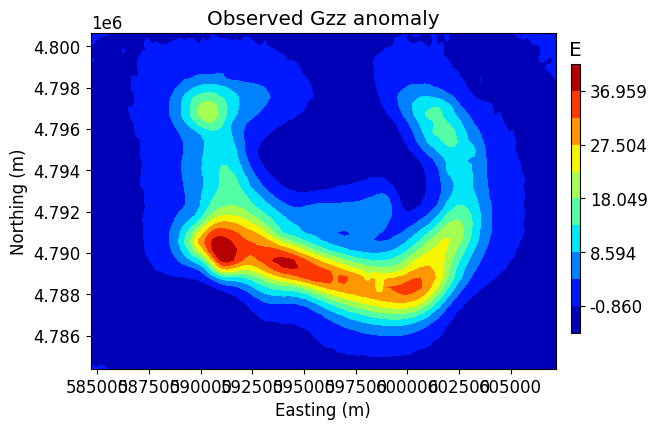

In [13]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot()
im = utils.plot2Ddata(xyzLoc, -dobs, ax=ax, contourOpts={"cmap": "jet"})
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('')
ax.locator_params(nbins=10, axis='x')
ax.set_title('Observed Gzz anomaly')
plt.gca().set_aspect('equal', adjustable='box')
pos = ax.get_position()
cb_ax = fig.add_axes([pos.x0+0.8, pos.y0+0.06, pos.width *0.02, pos.height*0.8])
kwargs = {'format': '%.3f'}
cb = plt.colorbar(im[0], cax=cb_ax, orientation="vertical", **kwargs)
cb.ax.set_title('E')


## Inverse problem (data misfit, regularization, optimization)

In [14]:
# create the forward model operator
simulation = gravity.simulation.Simulation3DIntegral(
    survey=data_object.survey, mesh=mesh, rhoMap=model_map, ind_active=actv
)

# data misfit term
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)
dmis.W = utils.sdiag(1 / uncertainties)

reg = regularization.Sparse(mesh, active_cells=actv, mapping=model_map)
reg.norms = [2, 2, 2, 2]
reg.alpha_s = 1

opt = optimization.ProjectedGNCG(
    maxIter=50, lower=-10.0, upper=10.0, maxIterLS=20, maxIterCG=500, tolCG=1e-3
)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)


## Iteration directives

In [15]:
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e-3)

update_IRLS = directives.Update_IRLS(
    f_min_change=1e-4,
    max_irls_iterations=20,
    coolEpsFact=5,
    beta_tol=1e-2,
    chifact_start = 3,
    chifact_target = 3,
)

save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
update_jacobi = directives.UpdatePreconditioner()
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

directives_list = [
    update_IRLS,
    sensitivity_weights,
    starting_beta,
    save_iteration,
    update_jacobi,
]

inv = inversion.BaseInversion(inv_prob, directives_list)

starting_model = np.ones(nC)*1e-8
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.12e-05  2.22e+07  0.00e+00  2.22e+07    1.49e+03      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 0.24051841788372497
   1  2.56e-05  7.02e+03  5.97e+07  8.54e+03    8.85e+02      0              
   2

In [16]:
plotting_map = maps.InjectActiveCells(mesh, actv, np.nan)
model_rec = plotting_map*(-1*recovered_model)
np.savetxt('model_dens.txt', model_rec)

dpred = inv_prob.dpred

nor_residual = (dobs-inv_prob.dpred) / uncertainties

## Model visualization

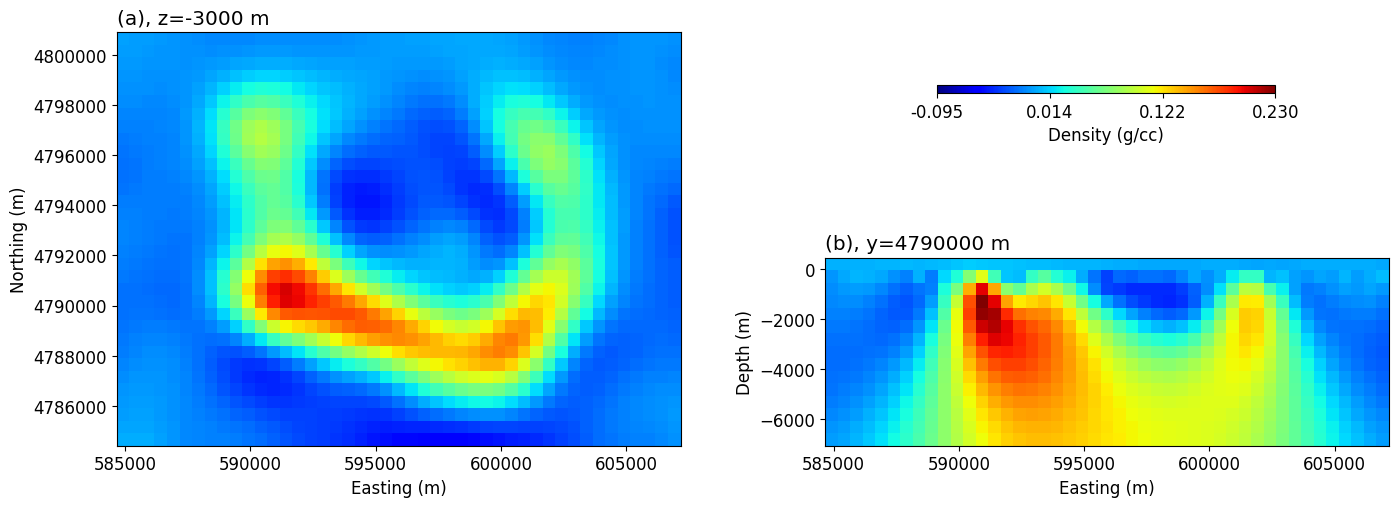

In [17]:
vmax0, vmin0 = np.nanmax(model_rec), np.nanmin(model_rec)

# density model
fig = plt.figure(figsize=(16,8))
# Plot horizontal section of inverted grav model
ax1 = plt.subplot(121)
slicePosition = -3000 #meter in z direction
sliceInd = int(round(np.searchsorted(mesh.cell_centers_z, slicePosition)))
mesh.plot_slice(model_rec, ax=ax1, normal='Z', ind=sliceInd,
           grid=False, clim=(vmin0, vmax0), pcolor_opts={"cmap":"jet"})
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
ax1.set_title('')
ax1.set_title('(a), z={} m'.format(slicePosition), loc='left')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.locator_params(nbins=6, axis='x')
ax1.set_aspect('equal', adjustable='box')
pos1 = ax1.get_position()

# Vertical section
ax2 = plt.subplot(122)
slicePosition = 4790000 #meter in y direction
sliceInd = int(round(np.searchsorted(mesh.cell_centers_y, slicePosition)))
im = mesh.plot_slice(model_rec, ax=ax2, normal='Y', ind=sliceInd,
           grid=False, clim=(vmin0, vmax0), pcolor_opts={"cmap":"jet"})
ax2.set_xlabel('Easting (m)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('')
ax2.set_title('(b), y={} m'.format(slicePosition), loc='left')
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.locator_params(nbins=6, axis='x')
ax2.set_aspect('equal', adjustable='box')
pos2 = ax2.get_position()
pos2_new = [pos2.x0+0.02, pos1.y0, pos2.width, pos2.height]
ax2.set_position(pos2_new)

cb_ax = fig.add_axes([pos2.x0+0.09, pos2.y0+0.3, pos2.width *0.6, pos2.height*0.04])
kwargs = {'format': '%.3f'}
cb = plt.colorbar(im[0], cax=cb_ax, orientation="horizontal",
              ticks=np.linspace(vmin0, vmax0, 4), **kwargs)
# cb.ax.tick_params(labelsize=16)
cb.set_label('Density (g/cc)')
# plt.savefig('plt_model_rec.png', bbox_inches="tight", dpi=300)

## Data visualization

Text(0.5, 1.0, 'E')

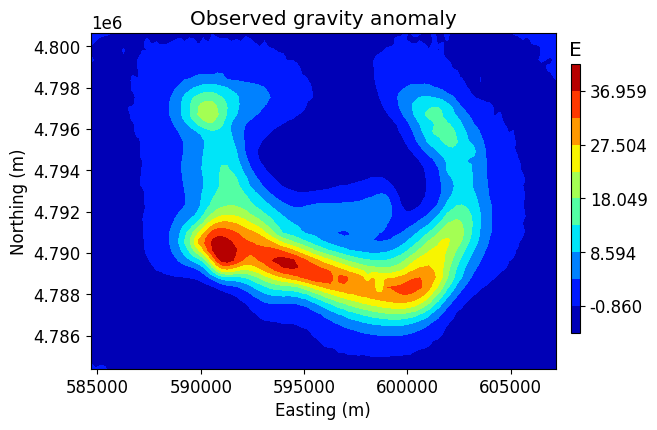

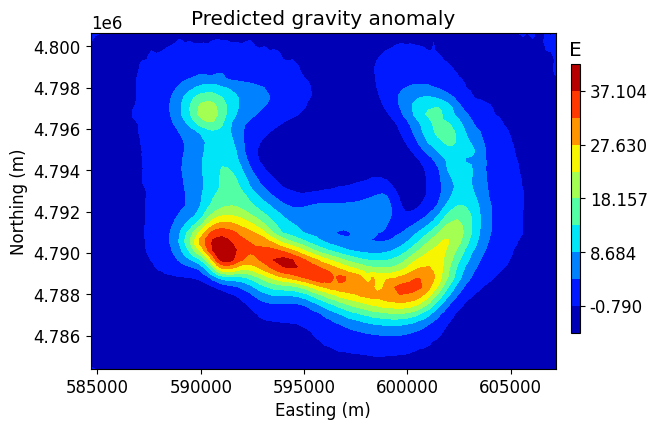

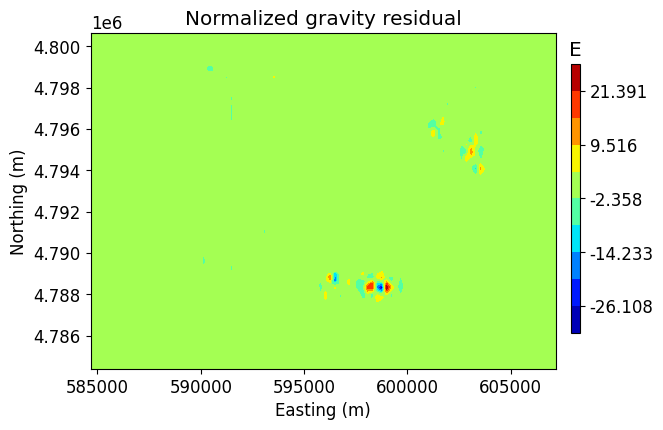

In [18]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot()
im = utils.plot2Ddata(xyzLoc, -dobs, ax=ax, contourOpts={"cmap": "jet"})
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('')
ax.locator_params(nbins=6, axis='x')
ax.set_title('Observed gravity anomaly')
plt.gca().set_aspect('equal', adjustable='box')
pos = ax.get_position()
cb_ax = fig.add_axes([pos.x0+0.8, pos.y0+0.06, pos.width *0.02, pos.height*0.8])
kwargs = {'format': '%.3f'}
cb = plt.colorbar(im[0], cax=cb_ax, orientation="vertical", **kwargs)
cb.ax.set_title('E')
# plt.savefig('plt_dobs.png', bbox_inches="tight", dpi=300)

# preditcted data
fig = plt.figure(figsize=(6,6))
ax = plt.subplot()
im = utils.plot2Ddata(xyzLoc, -dpred, ax=ax, contourOpts={"cmap": "jet"})
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('')
ax.locator_params(nbins=6, axis='x')
ax.set_title('Predicted gravity anomaly')
plt.gca().set_aspect('equal', adjustable='box')
pos = ax.get_position()
cb_ax = fig.add_axes([pos.x0+0.8, pos.y0+0.06, pos.width *0.02, pos.height*0.8])
kwargs = {'format': '%.3f'}
cb = plt.colorbar(im[0], cax=cb_ax, orientation="vertical", **kwargs)
cb.ax.set_title('E')
# plt.savefig('plt_dpred.png', bbox_inches="tight", dpi=300)


# data residual
fig = plt.figure(figsize=(6,6))
ax = plt.subplot()
im = utils.plot2Ddata(xyzLoc, -nor_residual, ax=ax, contourOpts={"cmap": "jet"})
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('')
ax.locator_params(nbins=6, axis='x')
ax.set_title('Normalized gravity residual')
plt.gca().set_aspect('equal', adjustable='box')
pos = ax.get_position()
cb_ax = fig.add_axes([pos.x0+0.8, pos.y0+0.06, pos.width *0.02, pos.height*0.8])
kwargs = {'format': '%.3f'}
cb = plt.colorbar(im[0], cax=cb_ax, orientation="vertical", **kwargs)
cb.ax.set_title('E')
# plt.savefig('plt_dnres.png', bbox_inches="tight", dpi=300)
